In [1]:
using LinearAlgebra
using Plots
using SparseArrays
using Arpack #Eigenvalues of sparse arrays with eigs()
using DifferentialEquations
# using DiffEqFlux
using Optim
using ForwardDiff
using DelimitedFiles
using LineSearches

In [2]:
#Def parameters
n_cutoff = 8
N = 2 * n_cutoff + 1
NHilbert = N^2
n = sparse(Diagonal(LinRange(-n_cutoff, n_cutoff, N))) #Perhaps implement using StaticArrays
Id = sparse(I, N, N)
exp_iPhi = spdiagm(-1 => ones(N - 1));

#Def Hamiltonian parameters
E_J_GHz = 10.0 #scale of E_J in units of h*GHz, h-bar = 1, h = 2pi
E_C = 1/100  #Charging energies
E_J = 1.0 #Josephson energies
phi_ext = 0.995pi

prefactor = 4 * E_C
Kinetic = 2pi * E_J_GHz * prefactor * (kron(n^2, Id) .+ kron(Id, n^2))

Potential1 = -2pi * E_J_GHz * kron(1 / 2 * (exp_iPhi .+ exp_iPhi'), Id) # -E_J1 cos(phi1)
Potential2 = -2pi * E_J_GHz * kron(Id, 1 / 2 * (exp_iPhi .+ exp_iPhi')) # -E_J2 cos(phi2)
Pot3Mat = kron(exp_iPhi, exp_iPhi')
Pot3Const = -2pi * E_J_GHz * E_J / 2

function get_Pot3(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return Pot3Const * (M + M')
end

function dPot3_dphi(Φ_ext = phi_ext)
    M = exp(im * Φ_ext) * Pot3Mat
    return (im * Pot3Const) .* (M - M')
end

Potential3 =  get_Pot3() #-E_J3 cos(phi1 - phi2 + phi_ext)
Potential12 = E_J * (Potential1 + Potential2)
KinPot12 = Kinetic + Potential12
chargecoupling = kron(n, Id);

In [3]:
# function limit_func(param,pmin,pmax)
#     if pmin <= param <= pmax
#         return param
#     elseif param < pmin
#         return pmin
#         # param = pmin
#     else
#         return pmax
#         # param = pmax
#     end
#     # return param
# end

function limit_func(param,pmin,pmax)
    (pmax - pmin) * (1/(1 + exp(-param))) + pmin
end

function inv_limit_func(param,pmin,pmax)
    # -log( (pmax - pmin  + 2e-8) / (param - pmin + 1e-8) - 1)
    -log( (pmax - pmin) / (param - pmin) - 1)
end

# function alpha(p, t)
#     Tₐ = limit_func(p[2],0,15)
#     Tₚ = 30 - 2*Tₐ#p[3]
#     αmin = limit_func(p[4],0.5,1)
#     abs_slope = (1 - αmin)/Tₐ
#     if t < Tₐ
#         return 1 - abs_slope * t
#     elseif t > Tₐ + Tₚ
#         return αmin + abs_slope * (t - Tₐ - Tₚ)
#     else
#         return αmin
#     end
# end

function alpha(p, t)
    Tₐ = 10#limit_func(p[2],0,15)
    Tₚ = 30 - 2*Tₐ#p[3]
    αmin = limit_func(p[1],0.5,1)
    abs_slope = (1 - αmin)/Tₐ
    if t < Tₐ
        return 1 - abs_slope * t
    elseif t > Tₐ + Tₚ
        return αmin + abs_slope * (t - Tₐ - Tₚ)
    else
        return αmin
    end
end

# dalphadt(p, t) = ForwardDiff.derivative(t̃ -> alpha(p,t̃), t)
dalphadp(p, t) = ForwardDiff.gradient(p̃ -> alpha(p̃,t), p)
# ddalphadpdt(p, t) = ForwardDiff.gradient(p̃ -> dalphadt(p̃,t), p)

# function envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
#     if Tₐ < t < Tₐ + Tᵣ
#         arg = pi / 2 * (t - Tₐ) / Tᵣ
#         E *= sin(arg)^2
#         Edot *= 2*sin(arg)*cos(arg)*pi/(2*Tᵣ)
#     elseif Tₐ + Tᵣ <= t <= Tₐ + Tₚ - Tᵣ
#         E *= 1
#         Edot *= 0
#     elseif Tₐ + Tₚ - Tᵣ < t < Tₐ + Tₚ
#         arg = pi / 2 * (Tₐ + Tₚ - t) / Tᵣ
#         E *= sin(arg)^2
#         Edot *= 2*sin(arg)*cos(arg)*(-pi)/(2*Tᵣ)
#     else
#         E *= 0
#         Edot *= 0
#     end
#     return (E, Edot)
# end

# function pulse2(p, t)
#     Tₐ = limit_func(p[2],0,15)
#     Tₚ = 30 - 2*Tₐ#p[3]
#     Tᵣ = limit_func(p[1],0,Tₚ/2)
#     # αmin = p[4]
#     ϕ = p[5]
#     f = p[6]
#     A = p[7]
#     # Φ_ext = p[8]
#     λ = p[9]

#     amp = pi * A #/ (Tₚ - Tᵣ)
#     E = amp
#     Edot = copy(amp)
#     # E, Edot = envelopes!(E, Edot, Tᵣ, Tₐ, Tₚ, t)
#     arg = f*(t - Tₐ) + ϕ
#     return E*cos(arg) + Edot*λ*sin(arg)
# end

# function envelope(t)
#     if t < 2
#         return sin(pi/4*t)^2
#     elseif 28 < t <= 30
#         return cos(pi/4*(t-28))^2
#     else
#         return 1
#     end
# end

h_times = LinRange(10,20,50+2)[2:end-1]
dt = h_times[2] - h_times[1]
function pulse(p, t)
    if  t < 10 || t > 20
        return 0
    end
    out = 0
    w_start = exp( - 5/(2*dt^2) * (t - 10)^2)
    w_end = exp( - 5/(2*dt^2) * (t - 20)^2)
    w_sum = w_start + w_end
    for (i, ht) in enumerate(h_times)
        w = exp( - 5/(2*dt^2) * (t - ht)^2)
        out += p[i+1] * w
        w_sum += w
    end
    # envelope(t)*out/w_sum
    out/w_sum
end

# dpulsedt(p, t) = ForwardDiff.derivative(t̃ -> pulse(p, t̃), t)
dpulsedp(p, t) = ForwardDiff.gradient(p̃ -> pulse(p̃, t), p)

dpulsedp (generic function with 1 method)

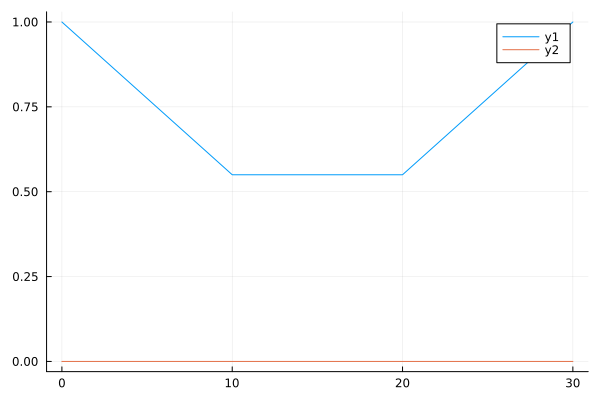

In [5]:
times = LinRange(0,30,1000)
# p = 
p = cat([inv_limit_func(0.55,0.5,1)],zeros(50),dims=1)#[pulse2(p,t) for t in h_times],dims=1)
plot(times,[[alpha(p,t) for t in times],[pulse(p,t) for t in times]])

In [162]:
# Es = eigvals(Matrix(KinPot12 + 0.7 .* Potential3))
# ψs = eigvecs(Matrix(KinPot12 + 0.7 .* Potential3));
# # ψs[:,1:2]'*KinPot12*ψs[:,1:2]
# # ψs[:,1:2]'*Potential3*ψs[:,1:2]
# # ψs[:,1:2]'*chargecoupling*ψs[:,1:2]
# ψs[:,1:2]'*KinPot12*ψs[:,1:2] + 0.7 .* ψs[:,1:2]'*Potential3*ψs[:,1:2]

2×2 Matrix{ComplexF64}:
     -76.0995+8.88178e-16im  1.73195e-14-2.66454e-15im
 -1.24345e-14+4.27436e-15im     -73.6169-6.66134e-16im

In [8]:
#[Tᵣ, Tₐ, Tₚ, αmin, ϕ, f, A, Φ_ext, λ]
# p = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
p = [2, 10, 10, 0.7, 0, 2.5, 0.1, 0.995pi, 0.0]
p[1] = inv_limit_func(p[1],0,15 - p[2])
p[2] = inv_limit_func(p[2],0,15)
p[4] = inv_limit_func(p[4],0.5,1)

-0.40546510810816466

In [6]:
alphas = LinRange(1,0.5,1000)
ψ0s = []
for alpha in alphas
    tmp_Es, tmp_ψs = eigs(KinPot12 + alpha .* Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000)
    push!(ψ0s, tmp_ψs)
end

function interpol_ψs(alpha)
    ind = argmin(abs.(alphas .- alpha))
    ψ0s[ind]
end

interpol_ψs (generic function with 1 method)

In [7]:
Es = eigvals(Matrix(KinPot12 + Potential3))
ψs = eigvecs(Matrix(KinPot12 + Potential3));

M = Pot3Const * exp(im * phi_ext) * Pot3Mat

# fu0 = ψs[:,1:2]

# N=30
# # Ua = ψs[:,1:N]'*Potential3*ψs[:,1:N]
# Um = ψs[:,1:N]'*(Pot3Const * exp(im * phi_ext) * Pot3Mat) * ψs[:,1:N]
# Uv = ψs[:,1:N]'*chargecoupling*ψs[:,1:N]
ψ0 = ψs[:,1:2]#zeros(N,2)
# ψ0[1,1] = 1.0
# ψ0[2,2] = 1.0

# u0 = ψs[:,1:2]#cat(real(Es[1:N].-Es[1]),Um,Uv,ψ0,dims=2)

Hphimærke = dPot3_dphi(phi_ext)
Hphi = KinPot12 + Potential3
IdNH = diagm(ones(ComplexF64, NHilbert))
E1mærke = ψs[:,1]'* Hphimærke * ψs[:,1]
E2mærke = ψs[:,2]'* Hphimærke * ψs[:,2]
tmp1 = - (Hphi - (real(Es[1]) .* IdNH)) \ (Hphimærke - (E1mærke .* IdNH))
tmp2 = - (Hphi - (real(Es[2]) .* IdNH)) \ (Hphimærke - (E2mærke .* IdNH))

fu0 = cat(ψ0,-tmp1*ψs[:,1],-tmp2*ψs[:,2],dims=2)
fu0 = cat(fu0,zeros(1,4),dims=1)
sizep = length(p)

51

In [8]:
m = 0.01/pi#0.001/pi #pi*2e-6
function f!(du, u, p, t)
    x = u[1:end-1,1:2]
    ψ = u[1:end-1,3:4]
    α = alpha(p,t)
    H = KinPot12 + α .* Potential3 + pulse(p,t) .* chargecoupling

    du[1:end-1,1:2] = -im .* (H * x)
    du[1:end-1,3:4] = -im .* (H * ψ) - α .* ((M - M') * x)

    tmp_ψs = interpol_ψs(α)

    proj = abs2.(tmp_ψs'*x)

    du[end,1] = sum(proj)
end

Uv = chargecoupling
Ua = Potential3#Um + Um'
dUa = M - M'

l1sscale = m

lfactor = 0.5/30 * l1sscale
function b!(du, u, p, t)
    x = u[:,1:2]
    ψ = u[:,3:4]
    λ = u[:,5:6]
    ϕ = u[:,7:8]
    α = alpha(p,t)
    dαdp = dalphadp(p,t)
    dpdp = dpulsedp(p,t)
    
    tmp_ψs = interpol_ψs(α)
    tψ0 = tmp_ψs[:,1]
    tψ1 = tmp_ψs[:,2]

    miH = -im .* (KinPot12 + α .* Potential3 + pulse(p,t) .* chargecoupling)

    du[:,1:2] = miH * x
    du[:,3:4] = miH * ψ - α * dUa * x
    du[:,5:6] = miH * λ - lfactor .* cat(tψ0 * (tψ0'*x[:,1]) + tψ1 * (tψ1'*x[:,1]), 
                                         tψ0 * (tψ0'*x[:,2]) + tψ1 * (tψ1'*x[:,2]),dims=2)
    du[:,7:8] = miH * ϕ + α * dUa * λ + lfactor .* cat(tψ0 * (tψ0'*ψ[:,1]) + tψ1 * (tψ1'*ψ[:,1]), 
                                                       tψ0 * (tψ0'*ψ[:,2]) + tψ1 * (tψ1'*ψ[:,2]),dims=2)
    
    du[1:sizep,9] = 2 .* (
    - real(im * tr(λ' * Uv * x)) .* dpdp 
    - real(im * tr(λ' * Ua * x)) .* dαdp )
    
    du[8,9] = 2 * real(tr(λ' * dUa * x) * α)
    
    du[sizep+1:2*sizep,9] = 2 .* (
    - real(im * (tr(ϕ' * Uv * x) + tr(ψ' * Uv * λ))) .* dpdp 
    - real(im * (tr(ϕ' * Ua * x) + tr(ψ' * Ua * λ))) .* dαdp 
    # + real(tr(ϕ' * (F .* Ua) * x) + tr(ψ' * (F .* Ua) * λ)) .* ddalphadpdt(p,t) 
    - real(tr(x' * dUa * λ)) .* dαdp )
    # - real(im * tr(x' * (F .* dUa)' * λ)) .* ddalphadpdt(p,t)
end

b! (generic function with 1 method)

In [9]:
ls = []
l1s = []
l2s = []
params = []
counter = [0]

grad = zeros(sizep)
loss = [0.0]

function calc(p, last_p, grad, loss)
    if p != last_p
        counter[1] += 1
        copy!(last_p, p)
        forward_prob = ODEProblem(f!, fu0, (0.0, 30.0), p)
        sol_f = solve(forward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        # DT = sol_f.u[end][:,1]
        # UmT = sol_f.u[end][:,2:N+1] #Ua = Um + Um'
        # UvT = sol_f.u[end][:,N+2:2*N+1]
        xT = sol_f.u[end][1:end-1,1:2]
        ψT = sol_f.u[end][1:end-1,3:4]

        UT = abs2.(ψ0'*xT)
        infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])
        int_inf = l1sscale - lfactor * real(sol_f.u[end][end,1])

        λ = 0.5 .* cat(ψ0[:,2]*ψ0[:,2]'*xT[:,1],ψ0[:,1]*ψ0[:,1]'*xT[:,2],dims=2)
        ϕ = 0.5 .* cat(-ψ0[:,2]*ψ0[:,2]'*ψT[:,1],-ψ0[:,1]*ψ0[:,1]'*ψT[:,2],dims=2)

        ps = zeros(289,1) #only 2*length(p) are possibly used
        bu0 = cat(xT,ψT,λ,ϕ,ps,dims=2);

        backward_prob = ODEProblem(b!, bu0, (30.0, 0.0), p)
        sol_b = solve(backward_prob, p=p, save_everystep=false, reltol=1e-8, abstol=1e-8)

        # UT = abs2.(ψ0'*xT)
        # infidelity = 0.5 * (2 - UT[1,2] - UT[2,1])
        grad_phi = real(sol_b.u[end][8,9])

        loss[1] = infidelity + int_inf + m * abs(grad_phi)
        grad[:] = real(sol_b.u[end][1:sizep,9]) + m * sign(grad_phi) .* real(sol_b.u[end][sizep+1:2*sizep,9])
        grad[8] = 0
        push!(ls, copy(infidelity))
        push!(l1s, copy(int_inf))
        push!(l2s, copy(grad_phi))
        push!(params, copy(p))

        if counter[1]%5 == 0
            image = plot([ls,ls + l1s + m .* abs.(l2s)],yscale=:log10,ylim=(1e-5,2))
            savefig(image,"tmp_loss.png")

            writedlm("tmp_awg55_lsmm22.txt",ls)
            writedlm("tmp_awg55_l1smm22.txt",l1s)
            writedlm("tmp_awg55_l2smm22.txt",l2s)
            writedlm("tmp_awg55_paramsmm22.txt",params)
        end
    end
end


function opt_func(p, last_p, grad, loss)
    calc(p, last_p, grad, loss)
    return loss[1]
end

function get_grad!(grad, p, last_p, loss)
    calc(p, last_p, grad, loss)
    println(ls[end]," ",l1s[end]," ",l2s[end]," ",loss[1])
end


get_grad! (generic function with 1 method)

In [10]:
initial_p = copy(p)
last_p = similar(initial_p);

In [11]:
res = optimize(p -> opt_func(p, last_p, grad, loss),
               (grad, p) -> get_grad!(grad, p, last_p, loss),
               initial_p,BFGS(linesearch=LineSearches.MoreThuente()))

0.9974570226393542 1.582123668650813e-7 -0.5993478725423648 0.9993649643826557


0.9956673745892505 1.654164381655228e-7 -0.814789496582854 0.9982610955248991


0.9861958693493338 2.179410739512437e-7 -1.4224934017723636 0.9907240244185613


0.9847520287759886 8.016885905581979e-7 1.8568460867498675 0.9906633551299208


0.9748293441234261 4.021534890431312e-7 -0.3349928520147001 0.975896061642887


0.9764395512476802 5.22044682779374e-7 0.7255682825841634 0.9787496288668424


0.9748373377050923 4.249128261321275e-7 -0.11593875980444779 0.9752068071522949


0.998264523683385 0.0020521945544798087 0.13932203168997717 1.0007601940383664


0.999241898163675 0.0007815800505038429 0.21851561323406926 1.000719035013958


0.9995411812677625 9.37369280917871e-5 -0.0614442502645885 0.9998305013189379


0.986201410547289 2.7942291092308228e-5 2.490210007880897 0.9941559374802044


0.9831733303985362 7.888831899760182e-6 -1.024986354421967 0.9864438521285959


0.9849983149168151 8.665486570936902e-7 1.9613014485815066 0.991242197874173


0.9749428439811725 4.538882186848857e-7 0.1444470230568589 0.9754030870240793


0.9748477669511146 4.3555532884499357e-7 -0.0201585496675397 0.9749123691629464


0.9731983608738726 5.563819027261038e-7 0.7745089764483836 0.9756642558971914


0.9741242382511882 4.685935857963973e-7 0.20999718178215937 0.974793148635094


0.9665183551874286 5.431104582670834e-7 0.12864948766911063 0.9669284023356625


0.9231062083277579 1.0590284958873764e-6 -0.3990630908406087 0.9243775246265101


0.5539862195558092 5.698994257742271e-6 -1.9668331868938405 0.5602525430286938


0.8766479866030497 7.252614939962749e-5 -9.283403847474348 0.9062705049733266


0.08675344269988627 1.8125859077605406e-5 0.06894350573092778 0.08699102255358711


0.058002854062437215 2.3355700606375075e-5 -1.3189864997706084 0.062224674189242976


0.17117191552864452 3.932903454172349e-5 -6.955955827888959 0.19335273964193436


0.046947274437672215 2.5782078346393844e-5 -2.2062386652806008 0.05399573230041607


0.11456053243759778 1.2281209581894645e-5 4.777570386365789 0.1297802925063711


0.009755704708985069 1.9752808315056866e-5 -0.0698140035980459 0.009997682392693413


0.007636952749406123 1.5030735667575113e-5 0.3643942895058491 0.008811886533259998


0.00434096122760963 1.2210475449385503e-5 0.0976078568534058 0.004663867161115528


0.0028325926699800386 1.0407983036697654e-5 -0.3169278165562424 0.0038518132251816844


0.0021451037742588053 9.665774573558786e-6 -0.1309025091661865 0.0025714451767709784


0.0018849897963410522 7.771583118936984e-6 0.37958477644655225 0.003101017249338006


0.0016316077590513012 8.759224678454771e-6 0.06456895688595747 0.0018458963569035081


0.0010869023845210823 8.137836595691669e-6 0.012286664401800826 0.0011341498885899305


0.0006440052476560099 7.422233598906262e-6 -0.23888404336314567 0.0014118190077953823


0.000601099650410275 7.56421547672137e-6 -0.08173150572874212 0.0008688233287484538


0.00031001277254461 7.336460029332484e-6 -0.03427583688157974 0.0004264526099402407


0.00030025630683078175 7.524497465616949e-6 0.06524573444563583 0.0005154644273500804


0.0002760512504482171 7.3637459766144955e-6 0.0020503973787862595 0.0002899416139875616


0.00026158636750511777 7.348784889894735e-6 -0.01273907822370749 0.00030948489778975986


0.00027179284055273145 7.359517409481764e-6 -0.0018999874836078355 0.0002852002059587916


0.0002462279561930014 7.348069193050932e-6 -0.00045795872002862863 0.00025503375326654424


0.0001581448769231164 7.365151962562388e-6 0.013500064645600645 0.00020848206929382837


0.00014827081807872178 7.28695753480146e-6 0.009100309619866406 0.00018452496080689255


0.00014631106970453 7.202404085521544e-6 0.0005215950065588331 0.00015517376226176932


0.000149506539937172 7.14290788796524e-6 -0.01153115249504376 0.0001933542462077904


0.0001456936331156733 7.19038441552005e-6 -0.0014917570186411607 0.00015763242759936873


0.00014609262623527242 7.198983065041624e-6 -3.7364114229412276e-5 0.00015341054296979126


0.00012920010693939776 7.184871285158528e-6 -0.00022285520288955321 0.00013709434836722869


0.00010808392376299158 7.195092966379591e-6 0.00030511794049581413 0.00011625023729848973


0.00010207529027728146 7.186266390640621e-6 0.00016681558804014182 0.00010979254717634947


7.547362079252107e-5 7.120062770910648e-6 -0.002190902638256301 8.956754325766301e-5


7.288279707506895e-5 7.112404603369996e-6 -0.002074911631076372 8.659985052973238e-5


7.152902567308939e-5 7.097675728451238e-6 -0.0018144064161116713 8.440213639957708e-5


7.10267582331725e-5 7.085723232875055e-6 -0.001278403344197844 8.218176569593349e-5


7.135438752181589e-5 7.062397723847733e-6 0.0010851921545576096 8.187105915771138e-5


7.037777580026772e-5 7.073090190142916e-6 -0.00012968412489802107 7.786366338077197e-5


7.460597320918527e-5 7.0493174116051036e-6 0.0056936752962202086 9.977882197586353e-5


6.990714907983975e-5 7.067094780910908e-6 0.0008845652369155011 7.978990245959777e-5


7.022068884532384e-5 7.071601028285721e-6 0.0001102021497397505 7.764307421101826e-5


6.662338276969271e-5 7.060663843840714e-6 0.0004861534090734637 7.523152097663378e-5


6.496573615377699e-5 7.060781650601589e-6 0.0007698472759972764 7.447701779239452e-5


6.471469385449513e-5 7.067083587968936e-6 0.0007470211420096788 7.415961958936392e-5


6.48021494188411e-5 7.083347431854729e-6 0.00040324490522027415 7.316906524954442e-5


6.540259367271428e-5 7.100086462999422e-6 -0.0003964458877304642 7.376460658972887e-5


6.489795179120961e-5 7.0902817202694694e-6 5.98829383289819e-5 7.217884682431756e-5


6.773060787673701e-5 7.1292452995894845e-6 -0.0029556079417946413 8.42678454518921e-5


6.487438059410433e-5 7.095855600509644e-6 -0.00043390283929686167 7.335139182852805e-5


6.487716457459491e-5 7.091442590649328e-6 -4.517441713258508e-5 7.211240180100317e-5


6.488597789522377e-5 7.090888307933248e-6 5.058745142830381e-6 7.199296868906349e-5


6.488117475034194e-5 7.091179856296391e-6 -2.1415614903839927e-5 7.20405226260643e-5


6.488452791597599e-5 7.09094643118989e-6 -1.3769332826369918e-6 7.197985726193067e-5


6.488521076841725e-5 7.090927807496157e-6 1.5446658344734041e-6 7.198105539997303e-5


6.488489111067253e-5 7.090942403593925e-6 -2.1823643302421546e-8 7.19759029810806e-5


6.48852009106915e-5 7.090919324766881e-6 1.1455629211337674e-6 7.19797666754888e-5


6.488519625375e-5 7.090943621125643e-6 8.780037589552516e-8 7.197641935215222e-5


6.488519284320038e-5 7.090938154082158e-6 1.2384960163653088e-7 7.197652522280854e-5


6.488495492845692e-5 7.090936661416792e-6 -2.956473248892274e-7 7.197683266453707e-5


6.488477795613123e-5 7.090938494391536e-6 -3.931943387848909e-8 7.197584160816799e-5


6.48847798954133e-5 7.090936736871192e-6 5.15083793766551e-8 7.197588058854826e-5


6.488477795613123e-5 7.090938494391536e-6 -3.931943387848909e-8 7.197584160816799e-5


6.361841722885009e-5 7.085192296759236e-6 -0.00011004569490586252 7.105389585181433e-5


6.214310160918002e-5 7.068850361423035e-6 -0.00041688902141172096 7.053895094017142e-5


6.175469185826232e-5 7.060548660414983e-6 -0.0004803254641913912 7.034416395705669e-5


6.117799257998602e-5 7.046894203277965e-6 -0.00045072310026866413 6.965958297073322e-5


6.0543241985844265e-5 7.036265972955227e-6 -0.0002458903544349965 6.836220126613845e-5


5.930473443582773e-5 7.023441177326107e-6 0.00044363468902368754 6.774030868685696e-5


5.767072179818644e-5 7.033515405118797e-6 0.000538541583515471 6.641846830484572e-5


5.633915799135858e-5 7.056358492263295e-6 0.0005955955301987907 6.529135593791339e-5


5.572584176982698e-5 7.059448949296807e-6 0.000623813468613808 6.477095066106756e-5


5.173558779075771e-5 7.066440667701998e-6 0.0008775617247133845 6.159539418558739e-5


4.8231413922572575e-5 7.0619725034844726e-6 0.0011235193756169326 5.886965967183614e-5


4.4516326331567324e-5 7.047547641165532e-6 0.0013021790196757863 5.570883852817205e-5


4.275341009341016e-5 7.031805694283216e-6 0.0011549861337816578 5.3461650835572334e-5


4.2471058361137626e-5 7.017338016754998e-6 0.0006767050163504132 5.1642415345237625e-5


4.332867399597928e-5 7.010005680274829e-6 4.33661691831296e-5 5.04767184800232e-5


4.472652255116394e-5 7.008605624085791e-6 -0.0006791702154894691 5.389699411516847e-5


4.3424738224606685e-5 7.009830517291753e-6 -2.1616160223945935e-5 5.050337511690459e-5


4.337269225490603e-5 7.009921682666481e-6 1.290166640046744e-5 5.042368121720765e-5


4.3407217767965633e-5 7.00986479397871e-6 -1.012385416374583e-5 5.044930779061038e-5


4.338448842117204e-5 7.0099011918851005e-6 4.972643687181488e-6 5.041021802951813e-5


4.339976361572573e-5 7.009881292524729e-6 -4.863676594613675e-6 5.042512647168312e-5


4.3389177190711337e-5 7.009889450600507e-6 2.104473233710391e-6 5.0405765387666836e-5


4.33960189406557e-5 7.009876877176e-6 -2.703671321344601e-6 5.0414501870937456e-5


4.339055111085566e-5 7.009890572451816e-6 9.448055504636486e-7 5.0403449092779815e-5


4.339434768130257e-5 7.009886690115957e-6 -1.2714611593979228e-6 5.040828155798788e-5


4.339133213615565e-5 7.009895766976748e-6 4.0658603786771105e-7 5.040252210668677e-5


4.3393549878478765e-5 7.009885915155133e-6 -8.264703014163381e-7 5.040606653030968e-5


4.339163128186385e-5 7.009893950866552e-6 2.945601624039518e-7 5.04024628468481e-5


4.3392698275135366e-5 7.009887637056834e-6 -5.2593452782258e-7 5.040426001378911e-5


4.3391802628522935e-5 7.00989638053413e-6 8.395517372982221e-8 5.040196624667501e-5


4.3392150814169916e-5 7.009889127497417e-6 1.5134971217635367e-7 5.04025217027639e-5


4.339179801143844e-5 7.009891137416558e-6 8.25884903587828e-8 5.040195203618466e-5


4.339211551968036e-5 7.009885247369861e-6 1.520643379017944e-7 5.040248480287112e-5


4.339181389900748e-5 7.009890077484468e-6 1.3921330202632814e-7 5.040214710619518e-5


4.339179801143844e-5 7.009891137416558e-6 8.25884903587828e-8 5.040195203618466e-5


4.686867935699279e-5 7.011049345364943e-6 -0.0017436251566333519 5.94298599539093e-5


4.359501913159258e-5 7.009779430168939e-6 -0.00016765658006023942 5.1138466030930904e-5


4.341127072643447e-5 7.009878051487083e-6 -1.699241754612745e-5 5.04752373228725e-5


4.339422176202756e-5 7.009876823439037e-6 -1.4663131343897606e-6 5.0408766005135775e-5


4.339202950759402e-5 7.009895222480009e-6 -1.2667168156272795e-7 5.040232793855944e-5


4.339185530988221e-5 7.00989229712734e-6 4.8189841075264663e-8 5.040190100003783e-5


4.339221336047139e-5 7.009890077978864e-6 -1.239943171906069e-7 5.0402498124620175e-5


4.3392101668371375e-5 7.0098895686193825e-6 -2.4413027604330804e-8 5.040206894607114e-5


4.3392193090574516e-5 7.009886057237225e-6 1.4512538676375152e-7 5.0402541096265175e-5


4.339186632418279e-5 7.00989237046451e-6 5.650101012828126e-8 5.0401938542948336e-5


4.339185530988221e-5 7.00989229712734e-6 4.8189841075264663e-8 5.040190100003783e-5


4.339186413504503e-5 7.0098928852246195e-6 3.035886040841533e-8 5.0401853655523664e-5


4.3391862611874554e-5 7.0098877574730975e-6 3.184877629807021e-8 5.040185174715124e-5


4.3391859102515085e-5 7.009894014841853e-6 2.270349374456534e-8 5.0401825384822034e-5


4.3391864342434694e-5 7.009889759825808e-6 4.985694675017001e-8 5.040191280185096e-5


4.3391859102515085e-5 7.009894014841853e-6 2.270349374456534e-8 5.0401825384822034e-5


4.339186163704323e-5 7.009890030705047e-6 3.849660944548768e-8 5.040187420626199e-5


4.3391859102515085e-5 7.009894014841853e-6 2.270349374456534e-8 5.0401825384822034e-5


7.530914742476247e-5 7.059969908192187e-6 -0.007323901467465268 0.00010568181975825633


4.417380379279079e-5 7.010022923160334e-6 -0.000608133706293727 5.311957642429995e-5


4.3455359102329005e-5 7.0098661502306266e-6 -5.9531701925054034e-5 5.0654720545200545e-5


4.339822859472653e-5 7.0098900257489424e-6 -5.718219517246039e-6 5.0426320278512554e-5


4.339249577278714e-5 7.009893327682322e-6 -5.982771354817841e-7 5.040429347573848e-5


4.33920803480925e-5 7.009893656912888e-6 2.058683767983637e-7 5.040262930440126e-5


4.3392198647795865e-5 7.009887044167381e-6 1.3251499148743957e-7 5.0402507500281826e-5


4.339220744270511e-5 7.0098916320820645e-6 1.446181180485506e-7 5.040255940855414e-5


4.3391859580854675e-5 7.009894015281171e-6 3.2969781008002545e-8 5.040185854220825e-5


4.3391859102515085e-5 7.009894014841853e-6 2.270349374456534e-8 5.0401825384822034e-5


 * Status: success

 * Candidate solution
    Final objective value:     5.040183e-05

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.39e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   9120  (vs limit Inf)
    Iterations:    54
    f(x) calls:    144
    ∇f(x) calls:   144


In [190]:
println("the amplitude is now A, not A/(Delta t)")
# writedlm("tmp_lsmm33_1.txt",ls)
# writedlm("tmp_l1smm33_1.txt",l1s)
# writedlm("tmp_l2smm33_1.txt",l2s)
# writedlm("tmp_paramsmm33_1.txt",params)

the amplitude is now A, not A/(Delta t)


In [28]:
function Forward(phi_ext,p̃)
    Potential3 = get_Pot3(phi_ext)

    alphas = LinRange(1,0.5,1000)
    ψ0s = []
    for alpha in alphas
        tmp_Es, tmp_ψs = eigs(KinPot12 + alpha .* Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000)
        push!(ψ0s, tmp_ψs)
    end
    function interpol_ψs(alpha)
        ind = argmin(abs.(alphas .- alpha))
        ψ0s[ind]
    end

    function f!(du, u, p, t)
        x = u[1:end-1,1:2]
        α = alpha(p,t)
        H = KinPot12 + α .* Potential3 + pulse(p,t) .* chargecoupling
        du[1:end-1,1:2] = -im .* (H * x)
        tmp_ψs = interpol_ψs(α)
        proj = abs2.(tmp_ψs'*x)
        du[end,1] = sum(proj)
    end

    E1s, ψ1s = eigs(KinPot12 + Potential3, nev=2, which=:SR)
    f0 = cat(ψ1s[:,1:2],zeros(1,2),dims=1)

    forward_prob = ODEProblem(f!, f0, (0.0, 30.0), p̃)
    sol = solve(forward_prob, p=p̃, save_everystep=false, reltol=1e-12, abstol=1e-12)

    UT = abs2.(ψ1s'*sol.u[end][1:end-1,:])
    return 0.5 * (2 - UT[1,2] - UT[2,1]) + 1 - lfactor * real(sol.u[end][end,1])
end
# Forward(p)

Forward (generic function with 2 methods)

In [141]:
tr(sol_b2.u[end][:,5:6]'*fu0[1:end-1,3:4])

-0.01867726691739212 + 0.0377325703101343im

In [142]:
sol_b2.u[end][1:18,end]

18-element Vector{ComplexF64}:
   2.895650393894463e-5 + 0.0im
   -0.04778821943199893 + 0.0im
                    0.0 + 0.0im
  -0.022187985375127693 + 0.0im
   0.003691149114146171 + 0.0im
   0.016515139383867217 + 0.0im
  -0.043772738003893454 + 0.0im
   -0.23892483965016273 + 0.0im
 -0.0003893305814137139 + 0.0im
   0.015877432894871348 + 0.0im
     3.0931109773264844 + 0.0im
                    0.0 + 0.0im
    0.16889583315514328 + 0.0im
     0.2079430945471711 + 0.0im
     1.7660391836686467 + 0.0im
     -2.243821127016253 + 0.0im
                    0.0 + 0.0im
    0.12963720275634125 + 0.0im

In [129]:
tr(sol_b.u[end][:,5:6]'*fu0[1:end-1,3:4])

0.15778865081321375 - 0.01576979103773582im

In [125]:
sol_b.u[end][1:18,end]

18-element Vector{ComplexF64}:
 4.2183969424888914e-5 + 0.0im
  -0.04045306587139466 + 0.0im
                   0.0 + 0.0im
  0.004899325709711725 + 0.0im
  0.005430538827964785 + 0.0im
  0.027625257130679426 + 0.0im
 -0.046086664965642156 + 0.0im
   0.10409454011735335 + 0.0im
  5.610371854944572e-5 + 0.0im
 -0.006927344066974074 + 0.0im
     11.73796818083005 + 0.0im
                   0.0 + 0.0im
     29.08213778654441 + 0.0im
 -0.003568216355279971 + 0.0im
    0.7089411936222716 + 0.0im
    1.5687863801688915 + 0.0im
                   0.0 + 0.0im
   0.13631127807109059 + 0.0im

In [127]:
((pp - pm)/(2*da) + (mp - mm)/(2*da))/2, (pp - pm - mp + mm)/(4*da*da)

(0.004864160887962932, 26.02793341965892)

In [107]:
grad

9-element Vector{Float64}:
  5.220220722307511e-7
 -0.001458712673904308
  0.0
  0.021144027963080875
  0.0008027452849758364
  0.006513126710083704
 -0.040862843485646984
  0.6115055010064017
  0.0004290216540655794

In [40]:
loss

1-element Vector{Float64}:
 0.9941374052035763

In [88]:
real(tr(etmp))

0.15778869492833647

In [89]:
grad

9-element Vector{Float64}:
  3.997844419993513e-5
 -0.03671634809509418
  0.0
  0.014156518950796563
  0.005429402874606194
  0.027850918992451634
 -0.04558730473116642
  0.10409418259444582
  9.949243770687898e-5

In [45]:
((pp - mp)/(2*da) + (pm - mm)/(2*da))/2

-0.08820613181914627

In [114]:
((pp - pm)/(2*da) + (mp - mm)/(2*da))/2 + m * (pp - pm - mp + mm)/(4*da*da)

0.01335498106987714

In [54]:
-0.04558730457161095*2

-0.0911746091432219

In [ ]:
[0,
-0.036500245835830974,#9.543793255684106,
0,
0.01510070118181591,#-225.36444932441668,
0,
1.0341194289775757,
-0.09242876567540129, #5.294008009748551,
0,
0]

In [34]:
# 1.0341194289775757/0.030241976405438555

In [126]:
da = 1e-5
dp = zeros(Float64,size(p))
dp[4] = da

pp = Forward(0.995*pi+da,p+dp)
pm = Forward(0.995*pi+da,p-dp)
mp = Forward(0.995*pi-da,p+dp)
mm = Forward(0.995*pi-da,p-dp)
(pp - pm - mp + mm)/(4*da*da)

26.02793341965892

In [143]:
lphis3 = [Forward(0.994*pi+a*1e-6,p) for a in range(-10,10,5)]

5-element Vector{Float64}:
 0.996110385050622
 0.9961094414897879
 0.9961084891041955
 0.9961075280008249
 0.996106552026214

In [145]:
(lphis3[end-1] - lphis3[1+1])/(1e-5)

-0.19134889629457416

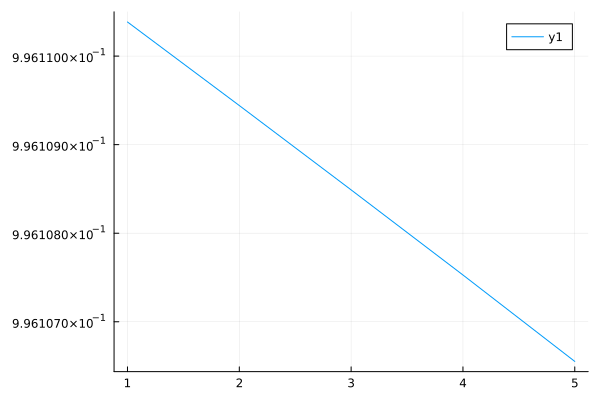

In [144]:
plot(lphis3)

In [112]:
(lphis2[end-1] - lphis2[1+1])/(1e-5)

0.7483052226864294

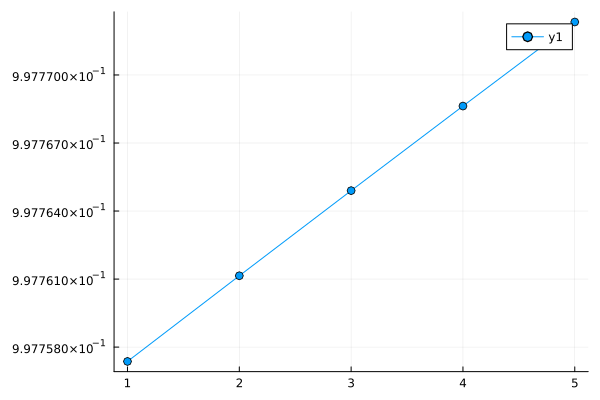

In [109]:
plot(lphis2,marker=:o)

In [71]:
(lphis[end-0] - lphis[1+0])/(2e-5)

-0.08921458903854428

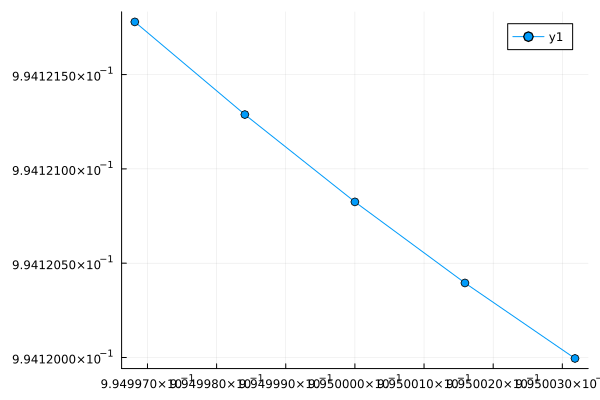

In [94]:
plot([0.995*pi+a*1e-6 for a in range(-10,10,5)]./pi,lphis,marker=:o)

In [ ]:
#2120 minutes
# res = optimize(p -> opt_func(p, last_p, grad, loss),
#                (grad, p) -> get_grad!(grad, p, last_p, loss),
#                initial_p,BFGS(linesearch=LineSearches.MoreThuente()))

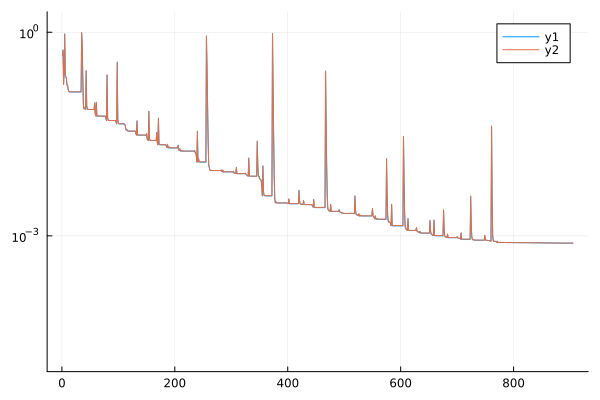

In [22]:
plot([l1s,l1s + m .* abs.(l2s)],yscale=:log10,ylim=(1e-5,2))

In [173]:
res #mm30_1

 * Status: success

 * Candidate solution
    Final objective value:     4.219505e-05

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.50e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   14701  (vs limit Inf)
    Iterations:    62
    f(x) calls:    180
    ∇f(x) calls:   180


In [128]:
res #mm30

 * Status: success

 * Candidate solution
    Final objective value:     1.128645e-04

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.07e-02 ≰ 1.0e-08

 * Work counters
    Seconds run:   7776  (vs limit Inf)
    Iterations:    62
    f(x) calls:    243
    ∇f(x) calls:   243


In [104]:
res #mm10

 * Status: success

 * Candidate solution
    Final objective value:     2.804587e-03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.26e+01 ≰ 1.0e-08

 * Work counters
    Seconds run:   9390  (vs limit Inf)
    Iterations:    12
    f(x) calls:    98
    ∇f(x) calls:   98


In [69]:
res #mm20

 * Status: success

 * Candidate solution
    Final objective value:     6.688301e-05

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 3.53e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   12214  (vs limit Inf)
    Iterations:    38
    f(x) calls:    209
    ∇f(x) calls:   209


In [16]:
res #mm2

 * Status: success

 * Candidate solution
    Final objective value:     9.968919e-01

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 2.27e+00 ≰ 1.0e-08

 * Work counters
    Seconds run:   9803  (vs limit Inf)
    Iterations:    27
    f(x) calls:    208
    ∇f(x) calls:   208


In [23]:
res

 * Status: success

 * Candidate solution
    Final objective value:     7.825282e-04

 * Found with
    Algorithm:     Gradient Descent

 * Convergence measures
    |x - x'|               = 8.30e-08 ≰ 0.0e+00
    |x - x'|/|x'|          = 8.30e-09 ≰ 0.0e+00
    |f(x) - f(x')|         = 6.59e-10 ≰ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 8.42e-07 ≤ 1.0e-06
    |g(x)|                 = 4.98e-03 ≰ 1.0e-04

 * Work counters
    Seconds run:   38952  (vs limit Inf)
    Iterations:    216
    f(x) calls:    905
    ∇f(x) calls:   905


In [174]:
p_new = copy(Optim.minimizer(res))
# # p_new = 
# # l1s = readdlm("tmp_l1sm5.txt")
# # l2s = readdlm("tmp_l2sm5.txt")

# plot(l1s + 0.00001/pi .* l2s, yscale=:log10,ylim=(4e-4,7e-4))

9-element Vector{Float64}:
 -0.4991024164678802
  0.8451558025810466
 10.0
 -0.3850305466966187
  0.06497379262661332
  2.0774836411474094
  2.651146468559904
  3.1258846903218442
 -0.18763483640310538

In [18]:
res

 * Status: success

 * Candidate solution
    Final objective value:     3.041432e-03

 * Found with
    Algorithm:     BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 6.69e-01 ≰ 1.0e-08

 * Work counters
    Seconds run:   16743  (vs limit Inf)
    Iterations:    45
    f(x) calls:    166
    ∇f(x) calls:   166


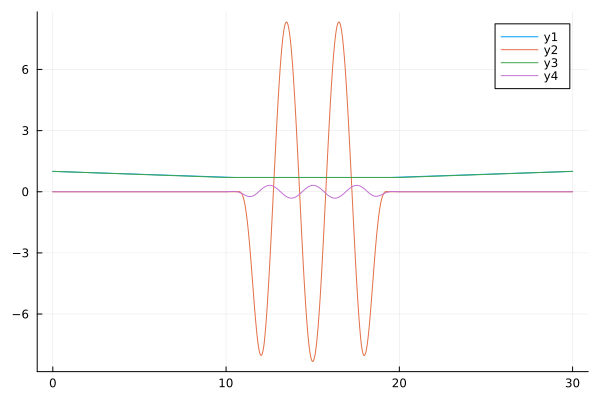

In [175]:
times = LinRange(0,30,1000)
plot(times, [[alpha(p_new,t) for t in times],
             [pulse(p_new,t) for t in times],
             [alpha(p,t) for t in times],
             [pulse(p,t) for t in times]])

In [10]:
# ls = readdlm("lsm3.txt")
# l1s = readdlm("l1sm3.txt")
# l2s = readdlm("l2sm3.txt")
# params = readdlm("paramsm3.txt") ;

In [53]:
# plot([ls,l1s,abs.(l2s)],yscale=:log)
p_new = params[63]

9-element Vector{Float64}:
  0.06500794044418902
  1.2813947332655746
 10.0
 -0.6934824862993917
 -0.18636352760995326
  2.9447594201602043
  2.9055862049182832
  3.1258846903218442
  0.03737639607984447

In [19]:
p_new = copy(Optim.minimizer(res));

In [176]:
times = LinRange(0,30,1000)
function f!(du, u, p, t)
    x = u[:,1:2]
    H = KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling
    du[:,1:2] = -im .* (H * x)
end
f0 = ψs[:,1:2]
forward_prob = ODEProblem(f!, f0, (0.0, 30.0), p_new)
sol_f = solve(forward_prob, p=p_new, saveat=times, reltol=1e-8, abstol=1e-8) ;

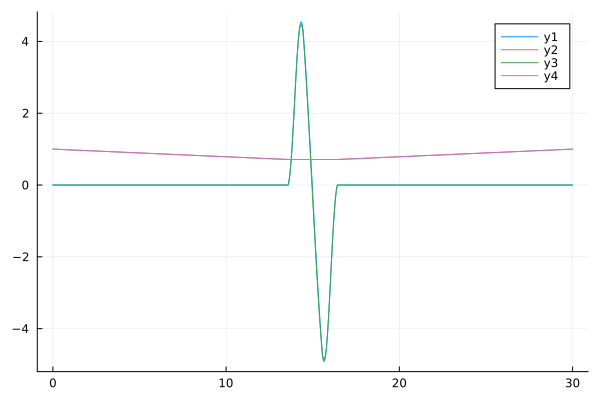

In [141]:
plot(times, [[pulse(params[130],t) for t in times],
             [alpha(params[130],t) for t in times],
             [pulse(params[end],t) for t in times],
             [alpha(params[end],t) for t in times]])

In [177]:
occs = zeros(Float64,length(sol_f.t),2,2)

for (i,t) in enumerate(sol_f.t)
    tmp_Es, tmp_ψs = eigs(KinPot12 + alpha(p,t) .* Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);
    occs[i,:,:] = abs2.(tmp_ψs'*sol_f.u[i])
end

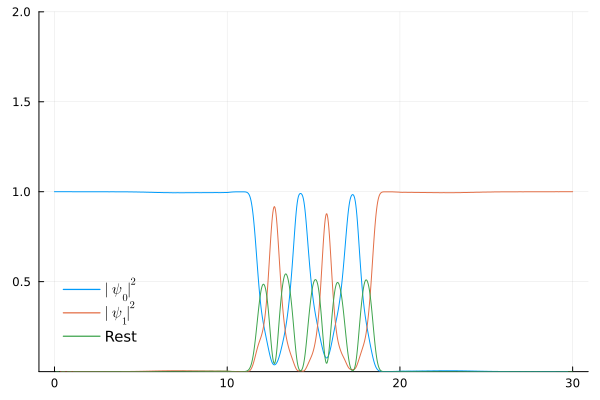

In [180]:
using LaTeXStrings
plot(sol_f.t,
    #  [occs[:,i,1] for i=1:20],
     [occs[:,[1,2],1], 1 .- sum(occs[:,[1,2],1],dims=2)],
     legend=:bottomleft,
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     label=[L"$|\psi_0|^2$" L"|\psi_1|^2" "Rest"],
    #  yscale=:log10,
     ylim=(1e-5,2),
    legendfontsize=10,
)

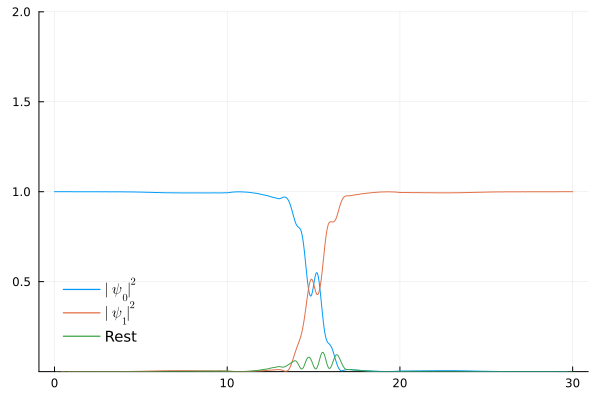

In [76]:
plot(sol_f.t,
    #  [occs[:,i,1] for i=1:20],
     [occs[:,[1,2],1], 1 .- sum(occs[:,[1,2],1],dims=2)],
     legend=:bottomleft,
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     label=[L"$|\psi_0|^2$" L"|\psi_1|^2" "Rest"],
    #  yscale=:log10,
     ylim=(1e-5,2),
    legendfontsize=10,
)

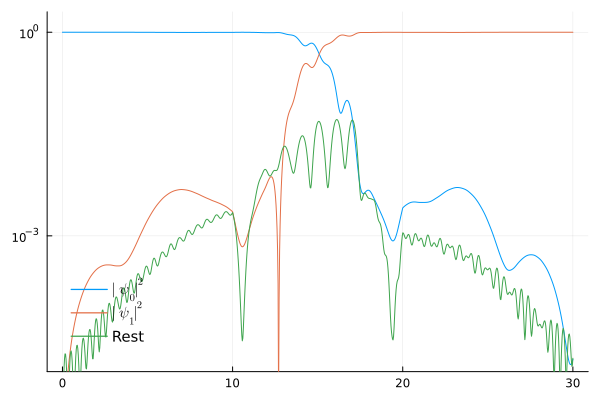

In [36]:
using LaTeXStrings
plot(sol_f.t,
    #  [occs[:,i,1] for i=1:20],
     [occs[:,[1,2],1], 1 .- sum(occs[:,[1,2],1],dims=2)],
     legend=:bottomleft,
     background_color_legend = nothing,
     foreground_color_legend = nothing,
     label=[L"$|\psi_0|^2$" L"|\psi_1|^2" "Rest"],
     yscale=:log10,
     ylim=(1e-5,2),
    legendfontsize=10,
)

In [28]:
# writedlm("tmp_l1sm4.txt",l1s)
# writedlm("tmp_l2sm4.txt",l2s)
# writedlm("tmp_paramsm4.txt",params)
# writedlm("tmp_callsm4.txt",calls)

In [181]:
function fidel(phi_ext,ps)
    Potential3 = get_Pot3(phi_ext)
    Es, ψs = eigs(KinPot12 + Potential3, nev=2, which=:SR, tol=0.0, maxiter=10000);

    function H!(du, u, p, t)
        du[:] = - im * (KinPot12 + alpha(p,t) .* Potential3 + pulse(p,t) .* chargecoupling) * u
    end

    forward_prob = ODEProblem(H!, ψs, (0.0, 30.0), ps)
    sol = solve(forward_prob, p=ps, save_everystep=false, reltol=1e-8, abstol=1e-10)

    UT = abs2.(ψs'*sol.u[end])
    return 0.5 * (2 - UT[1,2] - UT[2,1])
end    

fidel (generic function with 1 method)

In [182]:
tmp_losses7

UndefVarError: UndefVarError: tmp_losses7 not defined

In [183]:
phis = readdlm("../RobustPhiExt/phis.txt")

tmp_losses = []
for phi in phis
    push!(tmp_losses,fidel(phi*pi,p_new))
end

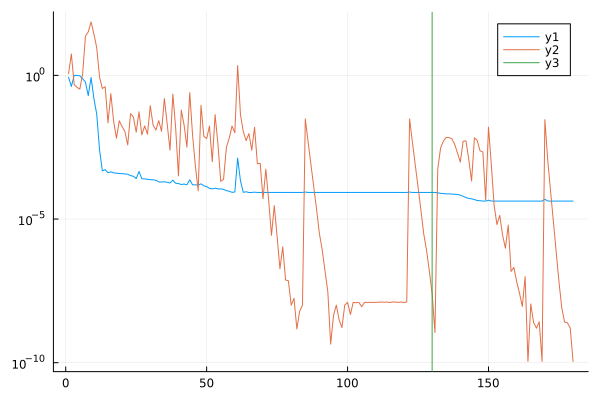

In [184]:
plot([ls,abs.(l2s)],yscale=:log10)
plot!([130],seriestype=:vline)

In [50]:
tmp_losses[15:20], tmp_losses2[15:20]

(Any[0.00011049478622543463, 5.867087790700776e-5, 4.1295336652258374e-5, 5.783732078801229e-5, 0.00010778274052536396, 0.00019063028651533642], Any[0.00010628789530126026, 5.49582435279139e-5, 3.792639063404657e-5, 5.451375335074893e-5, 0.00010404749531550683, 0.00018585993449604654])

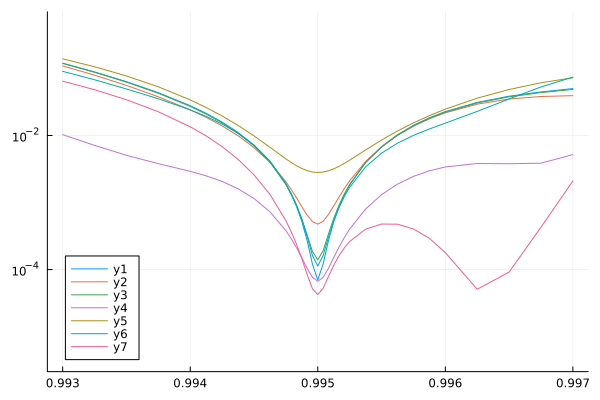

In [185]:
plot(phis,[tmp_losses,tmp_losses2,tmp_losses3,tmp_losses4,tmp_losses5,tmp_losses6,tmp_losses7],
yscale=:log10,
# marker=:o,
ylim=(3e-6,7e-1),
legend=:bottomleft)
# plot(phis,tmp_losses,yscale=:log10,marker="o",ylim=(3e-6,7e-1))
# savefig(fidelplot,"tmp_fidelplotm3.png")

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203


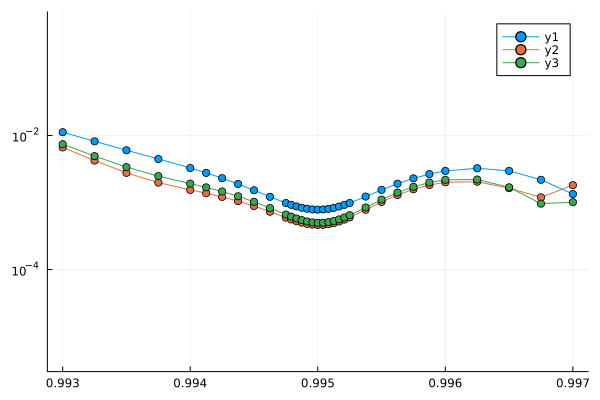

In [36]:
m0loss = readdlm("m0_phi_losses.txt")
m4loss = readdlm("m4_phi_losses.txt")
m5loss = readdlm("m5_phi_losses.txt")

plot(phis,[m4loss,m5loss,tmp_losses],yscale=:log10,marker="o",ylim=(3e-6,7e-1))

In [27]:
# writedlm("phis.txt",phis)
# writedlm("m5_phi_losses.txt",tmp_losses)

In [80]:
using ProgressMeter

In [84]:

# plot(phis,phis,marker="o")

In [85]:
tmp1_losses = []
# tmp2_losses = []
# tmp4_losses = []
tmp3_losses = []

p1 = [2, 10, 10, 0.7, 0.5418, 0.9763*2.482542369189332, 1.01556/0.2949509890806259, 0.995pi, 0.05289]
# p2 = copy(p_new)
# p4 = copy(readdlm("tmp_params5.txt")[end,:])
p3 = [1.8096066788458205,
10.151415509076779,
10.0,
0.7265360232227066,
2.819743639160394,
2.0448639414672374,
4.08982325027897,
3.1258846903218442,
0.03571156893603993]

# p3[2] = inv_limit_func(p3[2],0,15)
# p3[1] = inv_limit_func(p3[1],0,15 - p3[2])
# p3[4] = inv_limit_func(p3[4],0.5,1)

# p1[2] = inv_limit_func(p1[2],0,15)
# p1[1] = inv_limit_func(p1[1],0,15 - p1[2])
# p1[4] = inv_limit_func(p1[4],0.5,1)
# @showprogress for phi in [0.99pi, 0.991pi, 0.992pi, 0.993pi, 0.994pi,0.995pi,0.996pi, 0.997pi, 0.998pi, 0.999pi, pi]
@showprogress for phi in phis
    push!(tmp1_losses,fidel(phi*pi,p1))
    # push!(tmp2_losses,fidel(phi*pi,p2))
    # push!(tmp4_losses,fidel(phi*pi,p4))
    push!(tmp3_losses,fidel(phi*pi,p3))
end

Progress:   6%|███                                      |  ETA: 0:07:14

Progress:   9%|████                                     |  ETA: 0:06:49

Progress:  12%|█████                                    |  ETA: 0:06:30

Progress:  15%|███████                                  |  ETA: 0:06:15

Progress:  18%|████████                                 |  ETA: 0:05:58

Progress:  21%|█████████                                |  ETA: 0:05:43

Progress:  24%|██████████                               |  ETA: 0:05:32

Progress:  27%|████████████                             |  ETA: 0:05:19

Progress:  30%|█████████████                            |  ETA: 0:05:06

Progress:  33%|██████████████                           |  ETA: 0:04:53

Progress:  36%|███████████████                          |  ETA: 0:04:39

Progress:  39%|█████████████████                        |  ETA: 0:04:27

Progress:  42%|██████████████████                       |  ETA: 0:04:10

Progress:  45%|███████████████████                      |  ETA: 0:03:53

Progress:  48%|████████████████████                     |  ETA: 0:03:38

Progress:  52%|██████████████████████                   |  ETA: 0:03:23

Progress:  55%|███████████████████████                  |  ETA: 0:03:09

Progress:  58%|████████████████████████                 |  ETA: 0:02:55

Progress:  61%|█████████████████████████                |  ETA: 0:02:41

Progress:  64%|███████████████████████████              |  ETA: 0:02:28

Progress:  67%|████████████████████████████             |  ETA: 0:02:15

Progress:  70%|█████████████████████████████            |  ETA: 0:02:03

Progress:  73%|██████████████████████████████           |  ETA: 0:01:50

Progress:  76%|████████████████████████████████         |  ETA: 0:01:38

Progress:  79%|█████████████████████████████████        |  ETA: 0:01:25

Progress:  82%|██████████████████████████████████       |  ETA: 0:01:13

Progress:  85%|███████████████████████████████████      |  ETA: 0:01:01

Progress:  88%|█████████████████████████████████████    |  ETA: 0:00:49

Progress:  91%|██████████████████████████████████████   |  ETA: 0:00:36

Progress:  94%|███████████████████████████████████████  |  ETA: 0:00:24

Progress:  97%|████████████████████████████████████████ |  ETA: 0:00:12

Progress: 100%|█████████████████████████████████████████| Time: 0:06:42


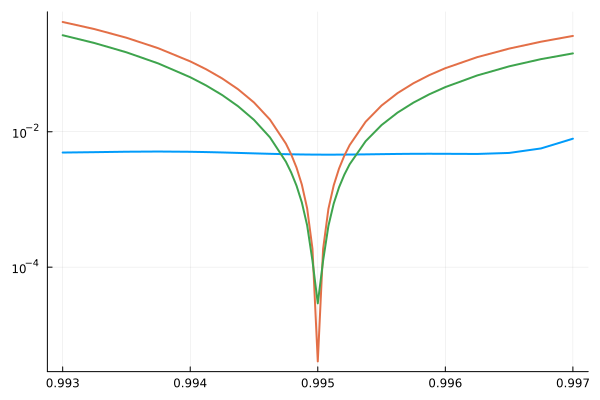

In [103]:
outputplot = plot(phis,[tmp_losses,tmp3_losses,tmp1_losses],yaxis=:log,linewidth=2,legend=nothing)

In [99]:
# savefig(outputplot,"BeautifulRobustness.pdf")

"c:\\Users\\jv97\\github\\Quantum-Optimal-Control\\Production\\BeautifulRobustness.pdf"

In [102]:
tmp1_losses./ones(11)

11-element Vector{Float64}:
 0.06382200265278937
 0.03991690415735
 0.021853458537448245
 0.00942874507165381
 0.002298652389022937
 2.9160349961532273e-5
 0.002149829165312145
 0.008195945371800739
 0.01773196293944468
 0.030350659263203628
 0.04564560806505197

┌ Warning: Skipped marker arg o.
└ @ Plots C:\Users\jv97\.julia\packages\Plots\jqILG\src\args.jl:1203


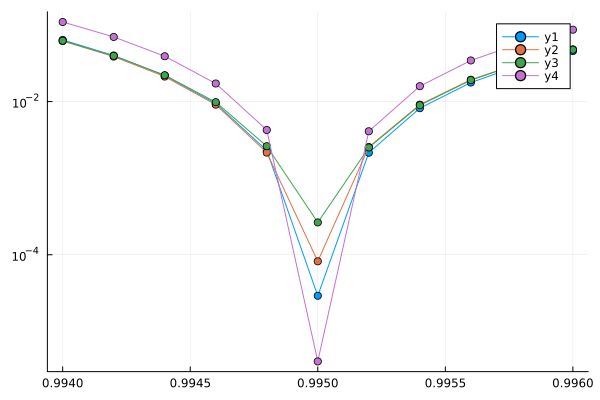

In [94]:
plot(LinRange(0.994,0.996,11),[tmp1_losses,tmp2_losses,tmp4_losses,tmp3_losses],yaxis=:log,marker="o")


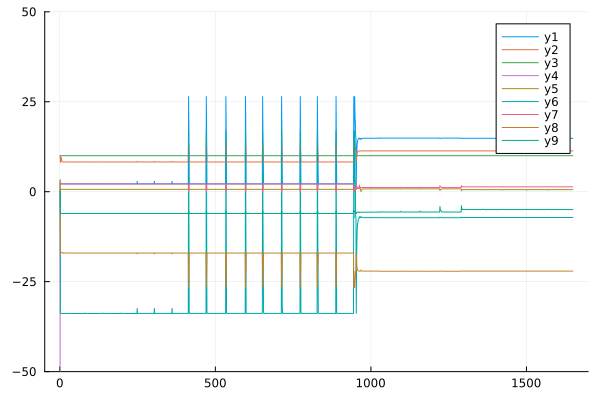

In [146]:
plot(transpose(cat(params...,dims=2)),ylim=(-50,50))


In [200]:
tmp = copy(p_new)
tmp[2] = limit_func(tmp[2],0,15)
tmp[1] = limit_func(tmp[1],0,15 - tmp[2])
tmp

9-element Vector{Float64}:
   1.5263572757019344
  11.472147443938331
  10.0
  -5.188952541845109
   0.6864151876375428
  -7.173438454226289
   0.7024191172650794
 -22.130712303163204
  -8.819182640524026

In [149]:
p_new

9-element Vector{Float64}:
   14.84292607534555
   11.341751839758764
   10.0
 -649.7661732132904
    0.5828557110984577
   -7.161153490188593
    1.3640811715268795
  -22.06506034791423
   -4.957612200539009